
## Projeto data science
#### Análise de dados Premier League 2023-24
#### Dupla: Henrique Melo (hcm) e Philippe Menge (pmal)



Definição do dataset

In [1632]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import median_abs_deviation, ttest_1samp
from scipy.spatial.distance import mahalanobis

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope




In [1633]:
df = pd.read_csv('PL23.csv')
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,NaN,NaN,1.92,1.95
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


In [1634]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Columns: 106 entries, Div to AvgCAHA
dtypes: float64(82), int64(16), object(8)
memory usage: 314.8+ KB


# Pré-processamento dos dados

Removemos todas as colunas relacionadas a apostas menos as médias, máximos e mínimos. 
Removemos também relacionadas a divisão da partida, data e hora.

In [1635]:

unused_columns = ['Div','Date','Time','Referee','B365>2.5','B365<2.5','P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA','B365H','B365D','B365A', 'BWH','BWD','BWA','IWH','IWD','IWA','PSH','PSD','PSA','WHH','WHD','WHA','VCH','VCD','VCA']
df.drop(unused_columns, axis=1, inplace=True)
df.head()


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,HY,AY,HR,AR,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Burnley,Man City,0,3,A,0,2,A,6,17,...,0,0,1,0,9.50,5.68,1.39,9.02,5.35,1.35
1,Arsenal,Nott'm Forest,2,1,H,2,0,H,15,6,...,2,2,0,0,1.21,8.50,17.50,1.18,7.64,15.67
2,Bournemouth,West Ham,1,1,D,0,0,D,14,16,...,1,4,0,0,2.80,3.62,2.75,2.69,3.44,2.64
3,Brighton,Luton,4,1,H,1,0,H,27,9,...,2,2,0,0,1.36,6.00,10.50,1.33,5.52,9.61
4,Everton,Fulham,0,1,A,0,0,D,19,9,...,0,2,0,0,2.30,3.57,3.45,2.24,3.43,3.30


Tratamentos de dados ausentes

In [1636]:
print('Verificando valores nulos:')
df.isnull().values.any()


Verificando valores nulos:


False

Definição dos tipos dos dados.

In [1637]:
print(df.dtypes)

HomeTeam     object
AwayTeam     object
FTHG          int64
FTAG          int64
FTR          object
HTHG          int64
HTAG          int64
HTR          object
HS            int64
AS            int64
HST           int64
AST           int64
HF            int64
AF            int64
HC            int64
AC            int64
HY            int64
AY            int64
HR            int64
AR            int64
MaxH        float64
MaxD        float64
MaxA        float64
AvgH        float64
AvgD        float64
AvgA        float64
dtype: object


# Normalização

In [1638]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['AvgH_normalized'] = scaler.fit_transform(df[['AvgH']])
df['AvgA_normalized'] = scaler.fit_transform(df[['AvgA']])
df['AvgD_normalized'] = scaler.fit_transform(df[['AvgD']])

# Limpeza de dados
## Univariado

In [1639]:
df['AvgH'].describe()


count    380.000000
mean       2.953737
std        2.337089
min        1.080000
25%        1.640000
50%        2.205000
75%        3.300000
max       18.020000
Name: AvgH, dtype: float64

In [1640]:
df['AvgH_normalized'].describe()

count    380.000000
mean       0.110610
std        0.137963
min        0.000000
25%        0.033058
50%        0.066411
75%        0.131051
max        1.000000
Name: AvgH_normalized, dtype: float64

<Axes: >

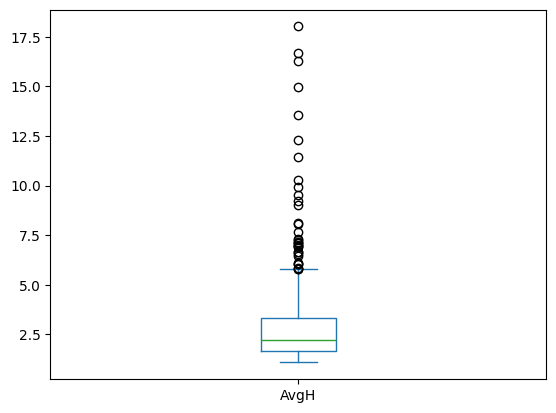

In [1641]:
df['AvgH'].plot.box()


<Axes: >

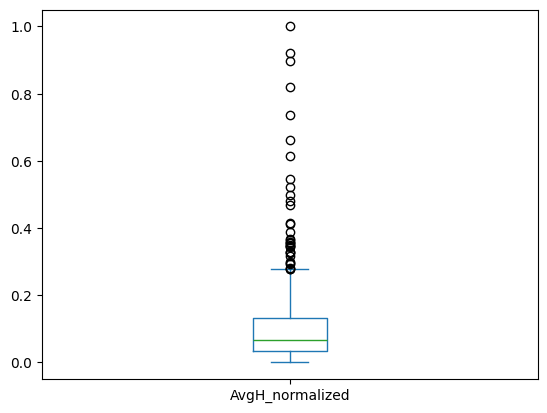

In [1642]:
df['AvgH_normalized'].plot.box()

<Axes: >

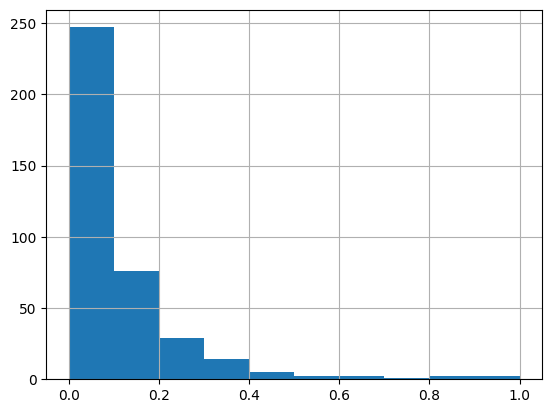

In [1643]:
df['AvgH_normalized'].hist()

In [1644]:
def detect_outliers_zscore_robust(data, threshold=3.5):
    if len(data) == 1:
        return np.array([False])
    
    median = np.median(data)
    mad = median_abs_deviation(data)
    z_scores = 0.6745 * (data - median) / mad
    outliers = np.abs(z_scores) > threshold
    return outliers

outliers = detect_outliers_zscore_robust(df['AvgH_normalized'])
print('Quantidade de outliers:', outliers.sum())

Quantidade de outliers: 31


<Axes: >

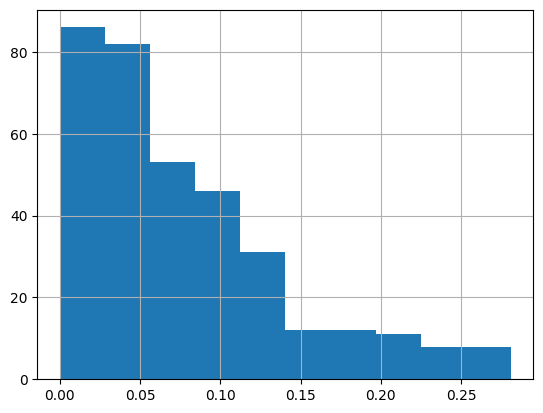

In [1645]:
df_filtered = df[~outliers]
df_filtered['AvgH_normalized'].hist()

## Bivariado

,Column 1,Column 2,Correlation
0,AvgA,AvgA_normalized,1.000000
1,AvgA_normalized,AvgA,1.000000
2,AvgH_normalized,AvgH,1.000000
3,AvgH,AvgH_normalized,1.000000
4,AvgD,AvgD_normalized,1.000000
5,AvgD_normalized,AvgD,1.000000
6,AvgH_normalized,MaxH,0.998475
7,MaxH,AvgH_normalized,0.998475
8,MaxH,AvgH,0.998475
9,AvgH,MaxH,0.998475


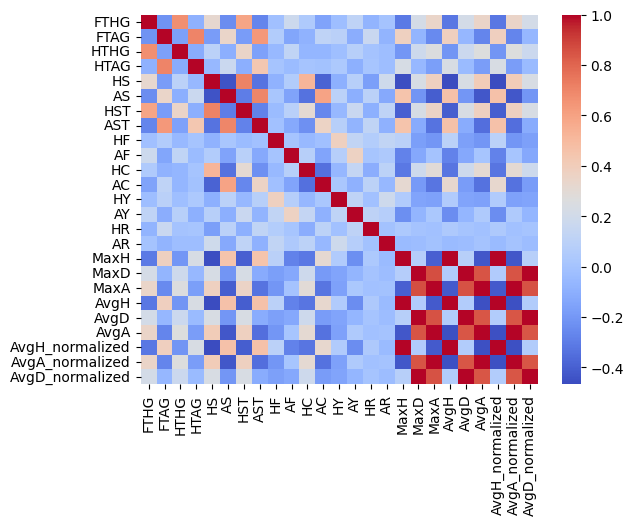

In [1646]:
# Selecionar apenas as colunas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Criar a matriz de correlação
correlation_matrix = numeric_columns.corr()

# Plotar a matriz de correlação
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Identificar as colunas com o maior grau de correlação
max_correlation = correlation_matrix.abs().unstack().sort_values(ascending=False)
max_correlation = max_correlation[max_correlation < 1]  # Excluir a correlação perfeita (1.0)
max_correlation = max_correlation.reset_index()
max_correlation.columns = ['Column 1', 'Column 2', 'Correlation']
max_correlation.head(50)

A partir da tabela de correlações, identificamos que Chutes ao gol do time da casa e Chutes totais do time da casa eram as duas colunas que envolviam dados do jogo com maior grau de correlação. Por isso, deicidimos analisá-las mais a fundo.

<Axes: xlabel='HS', ylabel='HST'>

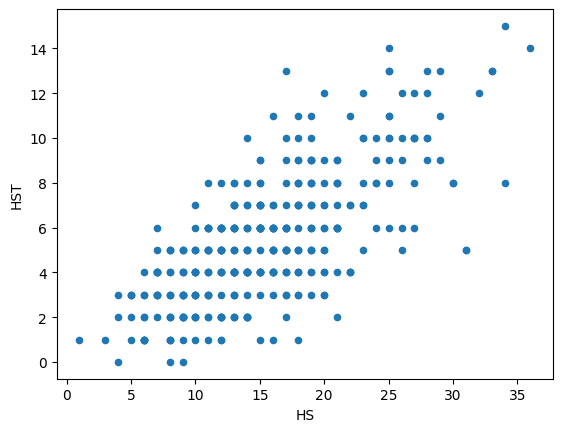

In [1647]:
df.plot.scatter(x='HS', y='HST')

Removemos os outliers utilizando o método isolation forest.

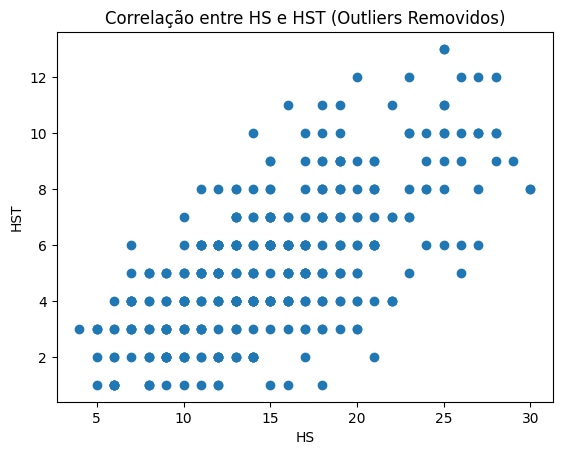

In [1648]:
# Cria um novo DataFrame com as colunas 'HS' e 'HST'
df_corr = df[['HS', 'HST']]

# Instancia o modelo IsolationForest
model = IsolationForest(n_estimators=100, contamination=0.05)

# Ajusta o modelo aos dados
model.fit(df_corr)

# Obtém as previsões de outliers
outliers = model.predict(df_corr)

# Adiciona a coluna 'Outlier' ao DataFrame original
df['Outlier'] = outliers

# Remove as linhas onde 'Outlier' é igual a -1
df_filtered = df[df['Outlier'] != -1]

# Plota o gráfico de correlação entre 'HS' e 'HST' com os outliers removidos
plt.scatter(df_filtered['HS'], df_filtered['HST'])
plt.xlabel('HS')
plt.ylabel('HST')
plt.title('Correlação entre HS e HST (Outliers Removidos)')
plt.show()

Removemos os outliers utilizando o método de Mahalanobis

<Axes: xlabel='HS', ylabel='HST'>

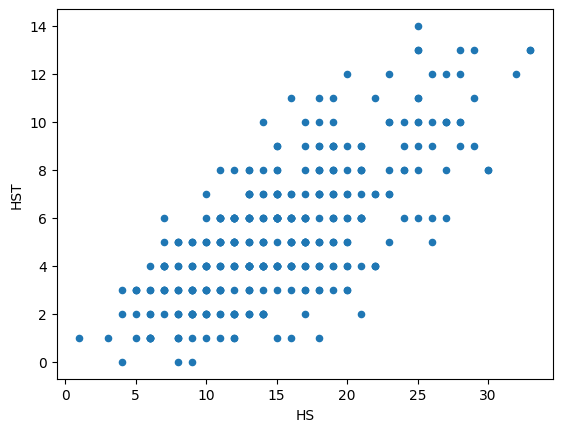

In [1649]:
# Calcular a matriz de covariância
cov_matrix = np.cov(df[['HS', 'HST']].values.T)

# Calcular a matriz de inversa da covariância
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calcular a média dos pontos
mean = np.mean(df[['HS', 'HST']].values, axis=0)

# Calcular a distância de Mahalanobis para cada ponto
distances = []
for point in df[['HS', 'HST']].values:
    distance = mahalanobis(point, mean, inv_cov_matrix)
    distances.append(distance)

# Definir um limite para remover os outliers
limit = np.mean(distances) + 3 * np.std(distances)

# Remover os outliers
df_filtered = df[distances <= limit]

# Plotar o gráfico sem os outliers
df_filtered.plot.scatter(x='HS', y='HST')

## Multivariado


Quando fizemos a análise anterior tivemos a ideia de que poderia existir uma relação tripla entre as duas variáveis que estávamos analisando e Gols totais dos times da casa, por isso resolvemos analisar também este caso.

<Axes: xlabel='HS', ylabel='HST'>

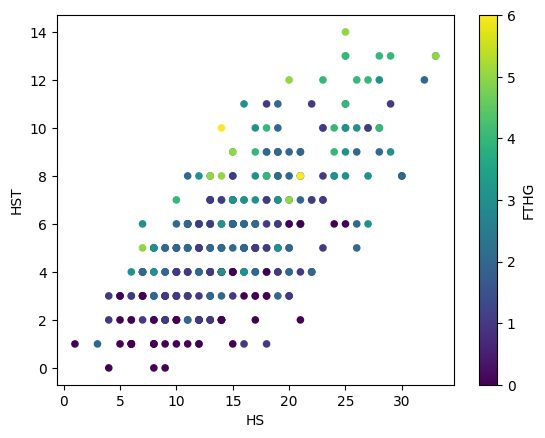

In [1650]:
df_filtered.plot.scatter(x='HS', y='HST', c='FTHG', colormap='viridis')

Removemos os outliers utilizando Elliptic Envelope

<Axes: xlabel='HS', ylabel='HST'>

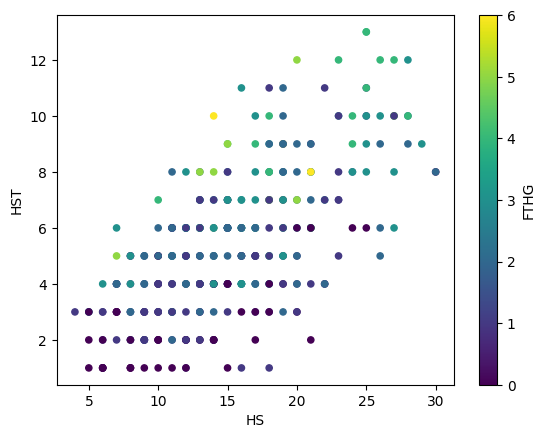

In [1651]:
# Create an instance of the EllipticEnvelope class
ee = EllipticEnvelope(contamination=0.01)

# Fit the EllipticEnvelope to the data
ee.fit(df[['HS', 'HST', 'FTHG']])

# Predict the outliers in the data
outliers = ee.predict(df[['HS', 'HST', 'FTHG']])

# Add a new column to the DataFrame indicating whether each row is an outlier
df['outlier'] = outliers

# Filtrar o DataFrame sem os outliers
df_filtered = df[df["Outlier"] == 1]

df_filtered.plot.scatter(x='HS', y='HST', c='FTHG', colormap='viridis')

# Análises

Agora, começamos a fazer análises mais profundas sobre questões que nos geravamo curiosidade como fãs de futebol.

Primeiramente, queríamos saber em qual metade do jogo eram feitos mais gols, já que existe o mito de que o segundo tempo é sempre o melhor. E talvez seja verdade... Percebemos que o segundo tempo é responsável por uma quantidade considerável maior de gols.

Total de Gols no Primeiro Tempo:  517
Total de Gols no Segundo Tempo:  729
Total de Gols na Partida:  1246
Porcentagem de Gols no Primeiro Tempo: 41.49%
Porcentagem de Gols no Segundo Tempo: 58.51%


<BarContainer object of 3 artists>

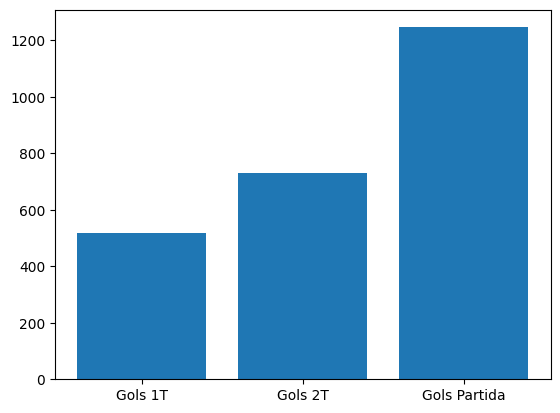

In [1652]:
total_FTHG = df['FTHG'].sum()
total_FTAG = df['FTAG'].sum()

total_HTHG = df['HTHG'].sum()
total_HTAG = df['HTAG'].sum()

total_FTG = total_FTHG + total_FTAG
total_HTG = total_HTHG + total_HTAG
total_STG = total_FTG - total_HTG


print("Total de Gols no Primeiro Tempo: ", total_HTG)
print("Total de Gols no Segundo Tempo: ", total_STG)
print("Total de Gols na Partida: ", total_FTG)

percentage_first_half = (total_HTG / total_FTG) * 100
percentage_second_half = (total_STG / total_FTG) * 100

print(f"Porcentagem de Gols no Primeiro Tempo: {percentage_first_half:.2f}%")
print(f"Porcentagem de Gols no Segundo Tempo: {percentage_second_half:.2f}%")

plt.bar(['Gols 1T', 'Gols 2T', 'Gols Partida'], [total_HTG, total_STG, total_FTG])



Queríamos saber também se o fator jogar em casa fazia muita diferença. Portanto, descobrimos que o time da casa detém a grande parte das vitórias e só sai com a derrota em menos de 1/3 dos casos.

In [1653]:
percentage_h = (df['FTR'].value_counts()['H'] / len(df['FTR'])) * 100
print(f"A porcentagem de valores 'H' na coluna 'FTR' é de {percentage_h:.2f}%")

percentage_d = (df['FTR'].value_counts()['D'] / len(df['FTR'])) * 100
print(f"A porcentagem de valores 'D' na coluna 'FTR' é de {percentage_d:.2f}%")

percentage_a = (df['FTR'].value_counts()['A'] / len(df['FTR'])) * 100
print(f"A porcentagem de valores 'A' na coluna 'FTR' é de {percentage_a:.2f}%")



A porcentagem de valores 'H' na coluna 'FTR' é de 46.05%
A porcentagem de valores 'D' na coluna 'FTR' é de 21.58%
A porcentagem de valores 'A' na coluna 'FTR' é de 32.37%


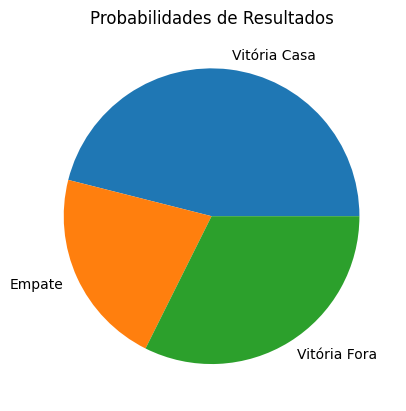

In [1654]:
plt.pie([percentage_h, percentage_d, percentage_a], labels=['Vitória Casa', 'Empate', 'Vitória Fora'])
plt.title('Probabilidades de Resultados')


plt.show()

Agora, gostaríamos de saber a relação entre o resultado favorito de acordo com as casas de aposta (o time com a menor odd) e o resultado da partida. Para isso, comparamos a média de cada opção de aposta (time da casa, empate e time de fora) com o resultado de cada partida e percebemos que o resultado favorito acontece em 58.95% dos casos.

In [1655]:
df['ExpectedResult'] = df[['AvgH', 'AvgD', 'AvgA']].idxmin(axis=1)

mapping = {'AvgH': 'H', 'AvgD': 'D', 'AvgA': 'A'}
df['ExpectedResult'] = df['ExpectedResult'].map(mapping)

matches = (df['ExpectedResult'] == df['FTR']).sum()

print(f"O resultado favorito aconteceu em {matches} partidas de {len(df)} possíveis")
porc = (matches / len(df)) * 100
print(f"Porcentagem de acontecimento dos resultados favoritos: {porc:.2f}%")

O resultado favorito aconteceu em 224 partidas de 380 possíveis
Porcentagem de acontecimento dos resultados favoritos: 58.95%


Aqui queríamos simular a situação de uma apostador que sempre aposta 5 reais no resultado favorito. 

In [1656]:
def calculate_amount(row, aposta=5):
    odds_mapping = {'H': 'AvgH', 'A': 'AvgA', 'D': 'AvgD'}

    if row['ExpectedResult'] == row['FTR']:
        return aposta * row[odds_mapping[row['ExpectedResult']]]
    else:
        return 0



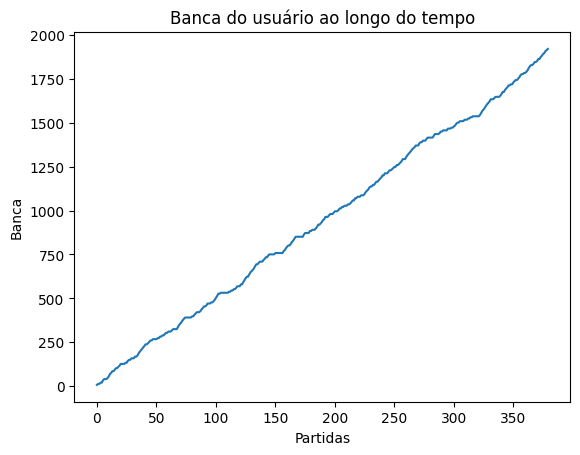

Simulações de apostas de 5 reais
O usuário realizou 380 apostas.
O usuário ganhou 20.30 reais.


In [1657]:
df['amount'] = df.apply(calculate_amount, axis=1)

# Soma cumulativa após cada aposta
df['cumulative_amount'] = df['amount'].cumsum()

plt.plot(df['cumulative_amount'])
plt.xlabel('Partidas')
plt.ylabel('Banca')
plt.title('Banca do usuário ao longo do tempo')
plt.show()


print(f'Simulações de apostas de 5 reais')
print(f"O usuário realizou {len(df['cumulative_amount'])} apostas.")
print(f"O usuário ganhou {df['amount'].sum()-(len(df['cumulative_amount']))*5:.2f} reais.")

### Analisamos se o Manchester City tem sempre odds baixas

- Hipótese nula -> As odds do Manchester City normalmente são abaixo de 1.5
- Hipótese alternativa -> As odds do Manchester City não necessariamente são abaixo de 1.5


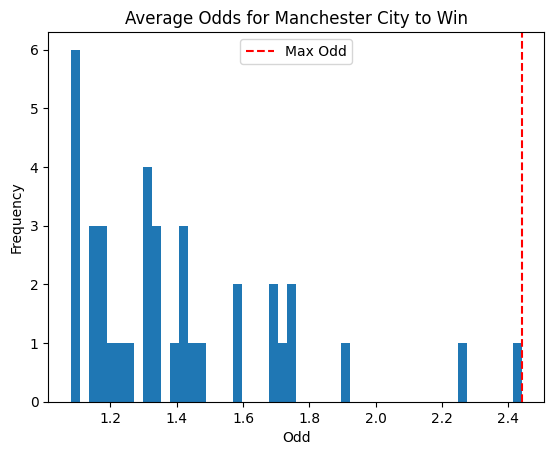

In [1658]:
# Filtrando para pegar as partidas do Manchester City
man_city_df = df[(df['HomeTeam'] == 'Man City') | (df['AwayTeam'] == 'Man City')]

odds_h = list(man_city_df.loc[man_city_df['HomeTeam'] == 'Man City', 'AvgH'])
odds_a = list(man_city_df.loc[man_city_df['AwayTeam'] == 'Man City', 'AvgA'])

odds = odds_h + odds_a

max_odds = max(odds)


plt.hist(odds, bins=50)

plt.xlabel('Odd')
plt.ylabel('Frequency')
plt.title('Average Odds for Manchester City to Win')
plt.axvline(x=max_odds, color='r', linestyle='--', label='Max Odd')
plt.legend()
plt.show()

In [1659]:
null_mean = 1.5
alpha = 0.05

# One-sample t-test
t_statisticA, p_valueA = ttest_1samp(odds, null_mean)

print("T-statistic Away:", t_statisticA)
print("P-value Away:", p_valueA)

if p_valueA < alpha:
    print("Hipótese nula rejeitada")
else:
    print("Hipótese nula aceita")

T-statistic Away: -1.8325832713977428
P-value Away: 0.0749218209494346
Hipótese nula aceita


Notamos que pode ser notada a segunda metade de uma gaussiana com pico perto de 1. Notamos assim que o Man City é o favorito na grande maioria de seus jogos.

### Analisamos também se os times favoritos de acordo com as odds eram os times mandantes.

- Hipótese nula -> A média das odds dos times mandantes são iguais as dos times visitantes.
- Hipótese alternativa -> As médias são diferentes.

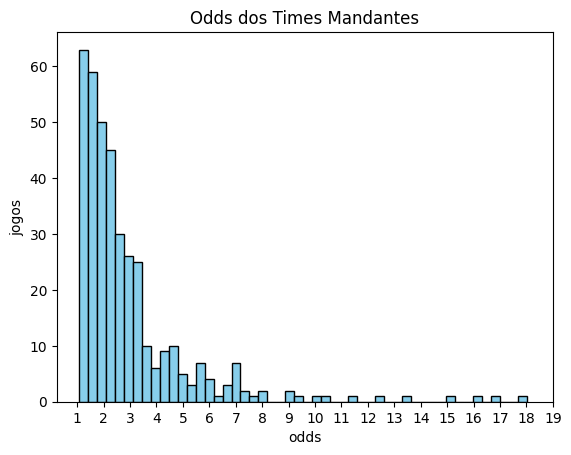

In [1660]:


odds_mandantes = list(df['AvgH'])

# Criar o gráfico de barras
plt.hist(odds_mandantes, bins=50, color='skyblue', edgecolor='black')

# Adicionar título e rótulos dos eixos
plt.title('Odds dos Times Mandantes')
plt.xlabel('odds')
plt.xticks([i for i in range(1, 20)])
plt.ylabel('jogos')

plt.show()


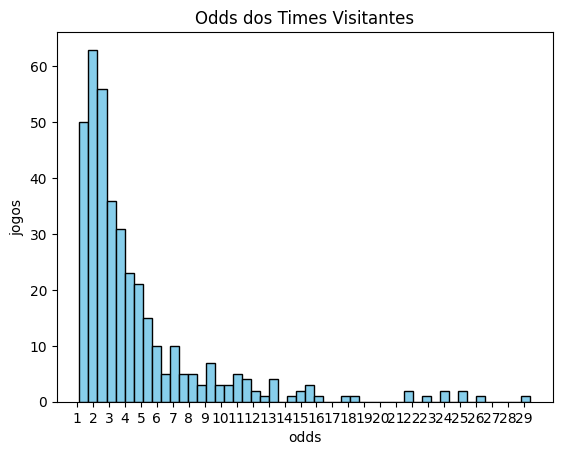

In [1661]:
odds_fora = list(df['AvgA'])

# Criar o gráfico de barras
plt.hist(odds_fora, bins=50, color='skyblue', edgecolor='black')



# Adicionar título e rótulos dos eixos
plt.title('Odds dos Times Visitantes')
plt.xlabel('odds')
plt.ylabel('jogos')
plt.xticks([i for i in range(1, 30)])

plt.show()

### Usamos o one-sample t-test para verificar as hipóteses

In [1662]:
meanH = df['AvgH'].mean()
meanD = df['AvgD'].mean()
meanA = df['AvgA'].mean()

std_devH = np.std(df['AvgH'])
std_devA = np.std(df['AvgA'])

print("Desvio Padrão Mandante:", std_devH)
print("Desvio Padrão Visitante:", std_devA)

# Definir a média da hipótese nula
null_mean = meanA

alpha = 0.05

# One-sample t-test
t_statisticH, p_valueH = ttest_1samp(odds_mandantes, null_mean)

print("\nT-statistic Home:", t_statisticH)
print("P-value Home:", p_valueH)

if p_valueH < alpha:
    print("\nHipótese nula rejeitada para Mandante")
else:
    print("\nHipótese nula aceita para Mandante")

null_mean = meanH

# One-sample t-test
t_statisticA, p_valueA = ttest_1samp(odds_fora, null_mean)

print("\nT-statistic Away:", t_statisticA)
print("P-value Away:", p_valueA)

if p_valueA < alpha:
    print("\nHipótese nula rejeitada para Visitante")
else:
    print("\nHipótese nula aceita para Visitante")

print("\nMédia de odds para os times mandantes:", meanH)
print("Média de odds para os times visitantes:", meanA)



Desvio Padrão Mandante: 2.334011733657992
Desvio Padrão Visitante: 4.454588733966489

T-statistic Home: -14.848902461939243
P-value Home: 1.2304328690644428e-39

Hipótese nula rejeitada para Mandante

T-statistic Away: 7.780182335092746
P-value Away: 6.942980287961144e-14

Hipótese nula rejeitada para Visitante

Média de odds para os times mandantes: 2.9537368421052634
Média de odds para os times visitantes: 4.733973684210526


Percebemos, portanto, que as duas curvas também fazem uma meia gaussiana, mas que na curva que representa as odds dos times visitantes o pico é mais para a direita (odds maiores), ou seja, os times favoritos são geralmente os que jogam em casa.

Utilizamos também do cálculo de p-value para mostrar que a média dos times que jogam em casa é menor do que a média dos times que jogam fora de casa, portanto os times que jogam em casa são favoritos

In [1663]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HomeTeam           380 non-null    object 
 1   AwayTeam           380 non-null    object 
 2   FTHG               380 non-null    int64  
 3   FTAG               380 non-null    int64  
 4   FTR                380 non-null    object 
 5   HTHG               380 non-null    int64  
 6   HTAG               380 non-null    int64  
 7   HTR                380 non-null    object 
 8   HS                 380 non-null    int64  
 9   AS                 380 non-null    int64  
 10  HST                380 non-null    int64  
 11  AST                380 non-null    int64  
 12  HF                 380 non-null    int64  
 13  AF                 380 non-null    int64  
 14  HC                 380 non-null    int64  
 15  AC                 380 non-null    int64  
 16  HY                 380 non

# Entrega 2


## Passos iniciais

In [1664]:
categorical_columns = ['HomeTeam', 'AwayTeam', 'FTR', 'HTR', 'ExpectedResult']
df.drop(categorical_columns, axis=1, inplace=True)
# Supondo que 'X' são as características e 'y' é o alvo
X = df.drop('AvgA', axis=1) 
y = df['AvgA']


In [1665]:
# Importando as bibliotecas necessárias
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dividindo os dados em conjuntos de treinamento e teste - teste com 20% dos dados, validação com 20% dos dados e treinamento com 60% dos dados.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [1666]:
def plot_predictions(y_true, y_pred):
    # Ordenar os valores reais e obter os índices ordenados
    sorted_indices = y_true.argsort().values
    y_true_sorted = y_true.iloc[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_true)), y_true_sorted, color='blue', label='Valores Reais')
    plt.scatter(range(len(y_pred)), y_pred_sorted, color='red', label='Valores Preditos')
    plt.xlabel('Índice Ordenado')
    plt.ylabel('Valores')
    plt.title('Comparação de Valores Reais e Preditos')
    plt.legend()
    plt.show()

### Regressão Linear

In [1667]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


def linearRegressionGS(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'fit_intercept': [True, False],
    }

    # Create the model
    model = LinearRegression()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5)

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    return best_params, best_score

In [1668]:
from sklearn.metrics import mean_squared_error

def linear_regression(X_train, y_train, X_test, y_test):
    # Criando e treinando o modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Fazendo previsões
    predictions = model.predict(X_test)

    # Avaliando o modelo
    mse = mean_squared_error(y_test, predictions)
    print(f"MSE: {mse}")

    plot_predictions(y_test, predictions)

    return mse

### Árvore de Decisão

In [1669]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

def decisionTreeGS(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 4, 6]
    }

    # Create the model
    model = DecisionTreeRegressor()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5)

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    return best_params, best_score

In [1670]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def decision_tree(X_train, y_train, X_test, y_test):
    # Criando e treinando o modelo
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Fazendo previsões
    predictions = model.predict(X_test)

    # Avaliando o modelo
    mse = mean_squared_error(y_test, predictions)
    print(f"MSE: {mse}")

    plot_predictions(y_test, predictions)

    return mse

### Random Forest

In [1671]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def randomForestGS(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Create the model
    model = RandomForestRegressor()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5)

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    return best_params, best_score

In [1672]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def random_forest(X_train, y_train, X_test, y_test):
    # Criando e treinando o modelo
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Fazendo previsões
    predictions = model.predict(X_test)

    # Avaliando o modelo
    mse = mean_squared_error(y_test, predictions)
    print(f"MSE: {mse}")

    plot_predictions(y_test, predictions)

    return mse

### SVM

In [1673]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

def svrGS(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }

    # Create the model
    model = SVR()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5)

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    return best_params, best_score

In [1674]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

def svr(X_train, y_train, X_test, y_test):
    # Criando e treinando o modelo
    model = SVR()
    model.fit(X_train, y_train)

    # Fazendo previsões
    predictions = model.predict(X_test)

    # Avaliando o modelo
    mse = mean_squared_error(y_test, predictions)
    print(f"MSE: {mse}")

    plot_predictions(y_test, predictions)
    

    return mse

In [1675]:
%pip install mlflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Linear Regression
Best Parameters: {'fit_intercept': True}
Best Score: 1.0
MSE: 1.3222502442610742e-29


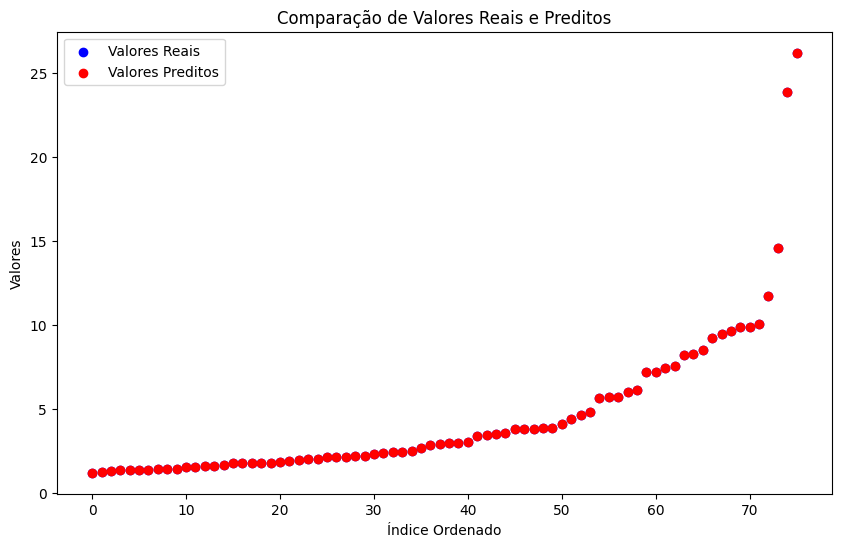

Decision Tree
Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 6}
Best Score: 0.9889130109357221
MSE: 0.09837105263157887


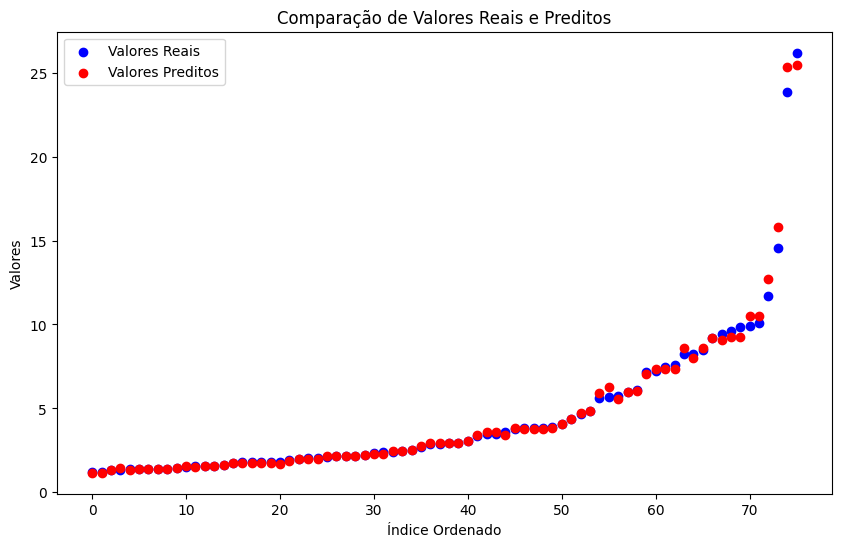

Random Forest
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9935648544510025
MSE: 0.1977953135526315


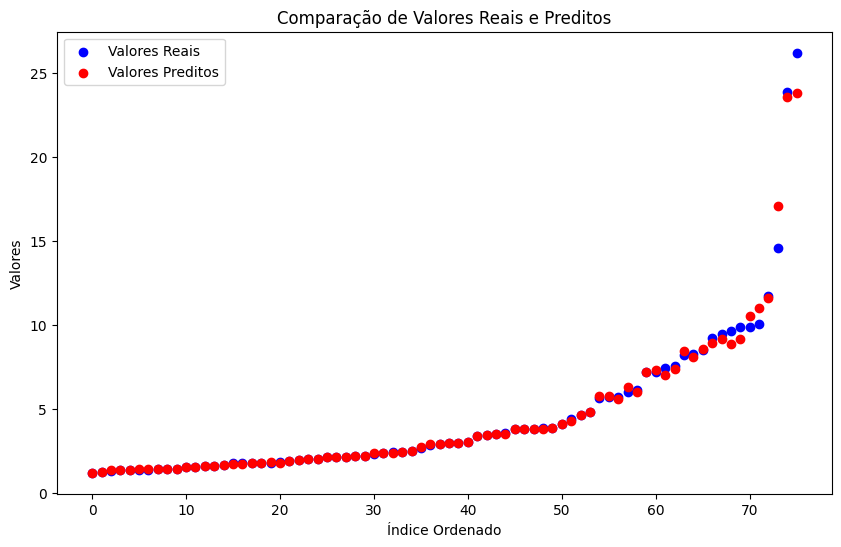

SVR
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9997720089656159
MSE: 10.9234497036415


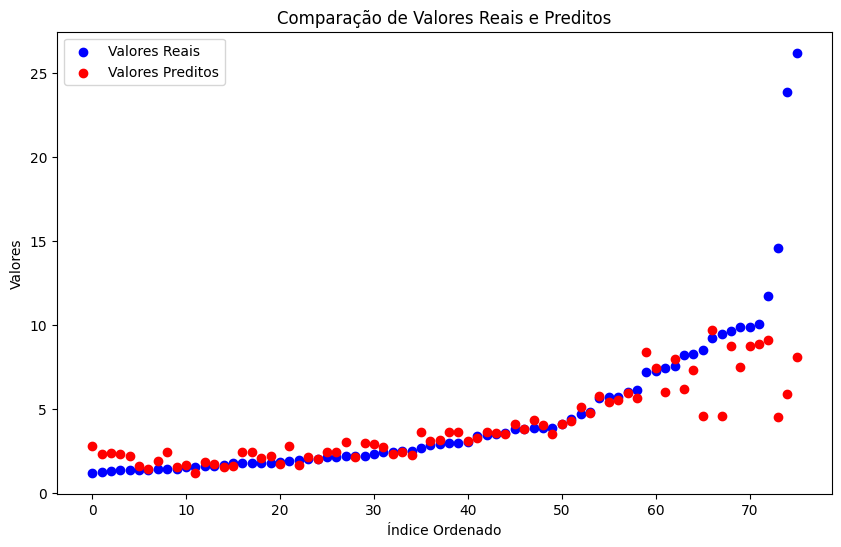

In [1676]:
import mlflow
import mlflow.sklearn

# Set the MLflow tracking URI
mlflow.set_tracking_uri("your_tracking_uri")

# Define uma função para executar e registrar um modelo
def train_and_log_model(model_name, model_func, train_func, X_train, y_train, X_test, y_test):
	with mlflow.start_run():
		print(model_name)
		best_params, best_score = train_func(X_train, y_train)
		predictions = model_func(X_train, y_train, X_test, y_test)

		mlflow.log_params(best_params)
		mlflow.log_metric("best score", best_score)
		mlflow.log_metric("mse", predictions)
		mlflow.sklearn.log_model(model, model_name)

# Executa e registra cada modelo em uma nova execução
train_and_log_model("Linear Regression", linear_regression, linearRegressionGS, X_train, y_train, X_test, y_test)
train_and_log_model("Decision Tree", decision_tree, decisionTreeGS, X_train, y_train, X_test, y_test)
train_and_log_model("Random Forest", random_forest, randomForestGS, X_train, y_train, X_test, y_test)
train_and_log_model("SVR", svr, svrGS, X_train, y_train, X_test, y_test)

# Não é necessário chamar mlflow.end_run() explicitamente ao usar o gerenciador de contexto with